In [2]:
#data import
from skimage.io import imread
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#gpu import
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#model imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.metrics import mean_squared_error

In [3]:
#setup GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs Available:  1


In [4]:
#image processing function
IMG_H = int(170/3)
IMG_W = int(432/3)
#IMG_D = 3
def preprocessImg(img):
    img = img[70:240,0:432] #170,432,3
    h,w,d = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.resize(img,(int(w/3),int(h/3)))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img/255.0
    return img

In [5]:
#read in pandas data
#1. read in full data
steeringDataAll = pd.read_csv('big100night/labeled_data.csv',header=None)
steeringData = steeringDataAll[:16200]
test_data = steeringDataAll[16200:]
#2. drop name of frame column
steeringDataNoImg = steeringData.drop(steeringData.columns[0:2],axis=1)
steeringDataNoImg

,2
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
16195,-1.0
16196,-1.0
16197,-1.0
16198,-1.0


In [6]:
#read in images to array + preprocess
dataDir = 'big100night/frames/'
dataFormat = '.jpg'
dataImages = []
for i in steeringData[0]:
    img = imread('{}{}{}'.format(dataDir,i,dataFormat), as_gray=False)
    img = preprocessImg(img)
    dataImages.append(img)

In [7]:
#images to numpy array
X = np.array(dataImages).reshape(-1,IMG_H,IMG_W,3)
steeringDataNoImg

,2
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
16195,-1.0
16196,-1.0
16197,-1.0
16198,-1.0


In [8]:
def preprocessPredImg(img):
    img = img[70:240,0:432] #170,432,3
    h,w,d = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.resize(img,(int(w/3),int(h/3)))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img/255.0
    return img.reshape(-1,IMG_H,IMG_W,3)

In [14]:
#reading in ResNet50V2
resnet = ResNet50V2(weights='imagenet', include_top=False,input_shape=X.shape[1:])

#removing last 4 layers which will be replaced
for layer in resnet.layers[:-4]:
    layer.trainable = False

#adding on 4 custom layers to resnet50v2    
def custom_resnet():
  model = tf.keras.Sequential()
  model.add(resnet)
    
  model.add(Dropout(0.5))  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=[mean_squared_error])
  return model
#creating custom ResNet50v2
resnet_custom = custom_resnet()
#traning the model
hist = resnet_custom.fit(X,steeringDataNoImg,epochs=2,batch_size=512, validation_split=0.1,verbose=1)

Epoch 1/2
29/29 [==============================] - 6s 151ms/step - loss: 8.8409 - mean_squared_error: 8.8409 - val_loss: 1.5674 - val_mean_squared_error: 1.5674
Epoch 2/2
29/29 [==============================] - 4s 125ms/step - loss: 2.3936 - mean_squared_error: 2.3936 - val_loss: 1.2928 - val_mean_squared_error: 1.2928


Text(0.5, 1.0, 'loss over time')

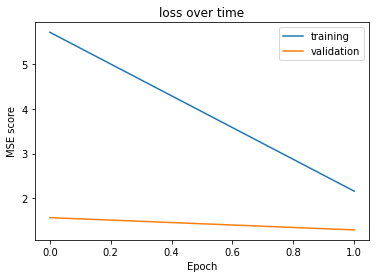

In [15]:
#plotting results
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('MSE score')
plt.xlabel('Epoch')
plt.title('loss over time')

In [ ]:
inc = 16200
for i in test_data[0]:
    testImage = imread('{}{}{}'.format(dataDir,i,dataFormat), as_gray=False)
    p = resnet1.predict([preprocessPredImg(testImage)])
    print("Number: {} Prediction value: {:.3f} Actual Value: {}".format(inc,p[0][0],test_data[2][inc]))
    inc+=1

In [ ]:
resnet1.save('resnight100_300.h5')